In [1]:
from pathlib import Path

import numpy as np
import torch
from ignite.metrics import PSNR, SSIM, MeanSquaredError
from matplotlib import pyplot as plt
from torch.utils.tensorboard.writer import SummaryWriter

from dynamic_fusion.network_trainer.configuration import TrainerConfiguration
from dynamic_fusion.network_trainer.network_loader import NetworkLoader
from dynamic_fusion.network_trainer.training_monitor import TrainingMonitor
from dynamic_fusion.utils.dataset import CocoTestDataset, collate_test_items
from dynamic_fusion.utils.evaluation import get_reconstructions_and_gt
from dynamic_fusion.utils.loss import LPIPS
import tempfile

/home/davton/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoints = [Path("../runs/00_ready_for_evaluation/02_implicit_msc_st-un"), 
               Path("../runs/00_ready_for_evaluation/03_implicit_msc_st-un_t-interp"), 
               Path("../runs/00_ready_for_evaluation/04_implicit_msc_st-un_st-interp")]

dataset_path = Path('..', 'data', 'interim', 'coco', 'test', '2subbins')
dataset = CocoTestDataset(dataset_path)
batch = collate_test_items([dataset[1]])

In [3]:
checkpoint_dir = checkpoints[2]

config_path = checkpoint_dir / "config.json"
with config_path.open("r", encoding="utf8") as f:
    json_config = f.read()
# Parse the JSON string back into a Configuration instance
config = TrainerConfiguration.parse_raw(json_config)

config.network_loader.decoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"
config.network_loader.encoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"

device = torch.device("cuda")

encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()
encoder = encoder.to(device)
decoder = decoder.to(device)

In [ ]:
from dynamic_fusion.utils.evaluation import get_metrics

metrics = get_metrics(dataset, encoder, decoder, config.shared, device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/davton/miniconda3/envs/thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/davton/miniconda3/envs/thesis/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/davton/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [5]:
from matplotlib import gridspec

from dynamic_fusion.utils.evaluation import add_plot_at_t
from dynamic_fusion.utils.visualization import create_red_blue_cmap, img_to_colormap

reconstrucion_flat, gt_flat, gt_downscaled, eps = get_reconstructions_and_gt(batch, encoder, decoder, config.shared, device, inference_region=None, Ts_to_evaluate=20, taus_to_evaluate=5)



In [23]:
fig = plt.figure(figsize=(16, 8))
plt.tight_layout()
# Define GridSpec layout
gs = gridspec.GridSpec(4, 5, figure=fig, height_ratios=[6,15,0,15])
table_ax = fig.add_subplot(gs[0, :])
table_data = [["{:.4f}".format(value) for value in metrics.values()]]
table_col_labels = list(metrics.keys())

# Add table to the subplot and remove axis
table = table_ax.table(cellText=table_data, colLabels=table_col_labels, loc='center', colWidths=[0.2] * 4)
table.auto_set_font_size(False)
table.scale(1,2)
table.set_fontsize(20)
table_ax.axis('off')


t = reconstrucion_flat.shape[0]//2
add_plot_at_t(t, gs, fig, 1, reconstrucion_flat, gt_flat, gt_downscaled, eps, True)


y = reconstrucion_flat.shape[1]//2
ax10 = fig.add_subplot(gs[3, 0])
ax10.imshow(reconstrucion_flat[:,y].T, cmap="gray", vmin=0, vmax=1, aspect='auto')
ax10.set_xlabel('T', fontsize=20)
ax10.set_ylabel(f'X, Y={y}', fontsize=20)

ax11 = fig.add_subplot(gs[3, 1])
ax11.imshow(gt_flat[:,y].T, cmap="gray", vmin=0, vmax=1, aspect='auto')
ax11.set_xlabel('T', fontsize=20)

ax12 = fig.add_subplot(gs[3, 2])
ax12.imshow(np.abs(gt_flat[:,y]-reconstrucion_flat[:,y]).T, cmap="gray", vmin=0, vmax=1, aspect='auto')
ax12.set_xlabel('T', fontsize=20)

Y = gt_downscaled.shape[1] // 2
ax13 = fig.add_subplot(gs[3, 3])
ax13.imshow(gt_downscaled[:,Y].T, cmap="gray", vmin=0, vmax=1, aspect='auto')
ax13.set_xlabel('T', fontsize=20)

ax14 = fig.add_subplot(gs[3, 4])
ax14.imshow(img_to_colormap(eps[:,:,Y].sum(axis=1), create_red_blue_cmap(501)).transpose(1,0,2), cmap="gray", vmin=0, vmax=1, aspect='auto')
ax14.set_xlabel('T', fontsize=20)

writer.add_figure('test1', fig)
writer.flush()


plt.show()



: 

In [8]:
import io
from dynamic_fusion.utils.evaluation import get_evaluation_video
import tempfile
from torchvision.io import read_video

ani = get_evaluation_video(reconstrucion_flat, gt_flat, gt_downscaled, eps, frames=range(0, 100))
#ani.save('animation_newer.mp4', writer='ffmpeg', fps=10) # Adjust fps (frames per second) as needed

with tempfile.NamedTemporaryFile(delete=True, suffix=".mp4") as temp_file:
    ani.save(temp_file.name, writer='ffmpeg', fps=10)
    vid, _, _ = read_video(temp_file.name)

import einops
vid = einops.rearrange(vid, "T H W C -> 1 T C H W")

writer = SummaryWriter('test')  # type: ignore[no-untyped-call]
writer.add_video('test', vid)
writer.flush()



In [9]:
vid.shape

torch.Size([1, 100, 3, 400, 1600])

: 

Text(0.5, 0, 'X')

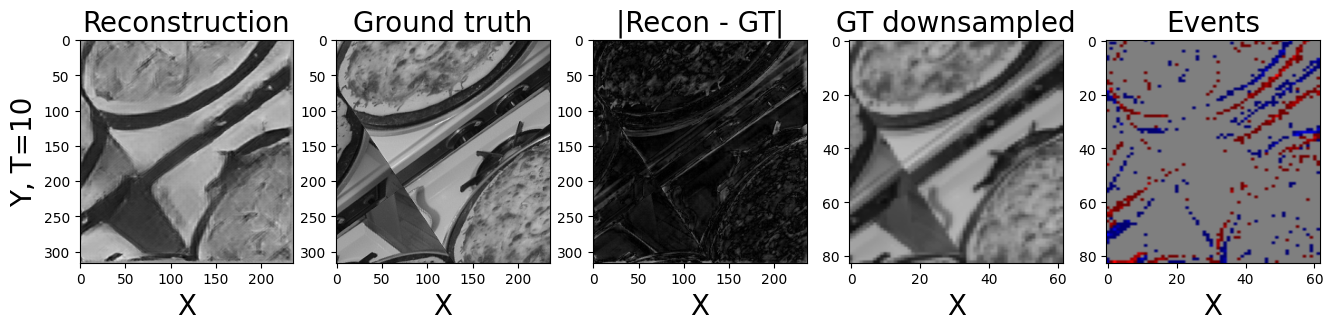

In [18]:
t = 10
fig = plt.figure(figsize=(16, 8))
plt.tight_layout()

gs = gridspec.GridSpec(4, 5, figure=fig, height_ratios=[6,15,0,15])

In [82]:
gt_flat.shape

(25, 316, 236)

In [66]:
TrainingMonitor.img_to_colormap(eps[:,:,:,Y].sum(axis=1), TrainingMonitor.create_red_blue_cmap(501)).shape

(6, 83, 3)

In [50]:
ssim_obj = PSNR(data_range=1)
ssim_obj.update(output=[torch.tensor(reconstrucion_flat[:, None]).to(device), torch.tensor(gt_flat[:, None]).to(device)])
ssim_obj.compute()

18.435075139367246

<Figure size 640x480 with 0 Axes>

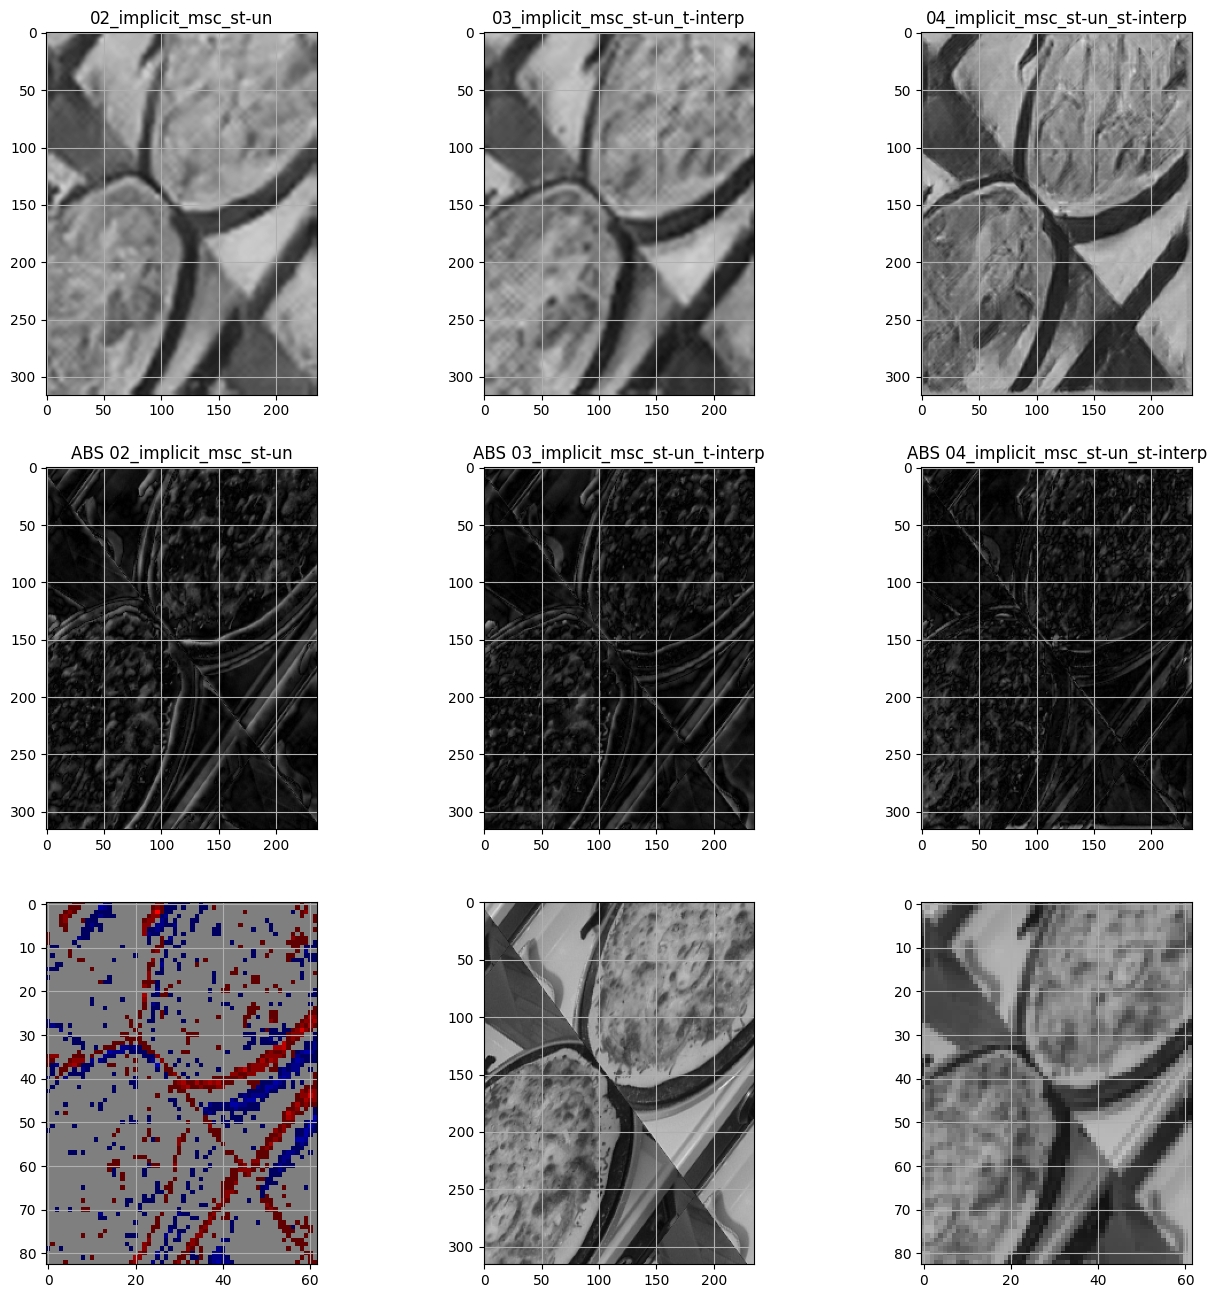

In [3]:

plt.tight_layout()

fig, axs = plt.subplots(3, 3, figsize=(16, 16))

for i, checkpoint_dir in enumerate(checkpoints):
    config_path = checkpoint_dir / "config.json"
    with config_path.open("r", encoding="utf8") as f:
        json_config = f.read()
    # Parse the JSON string back into a Configuration instance
    config = TrainerConfiguration.parse_raw(json_config)

    config.network_loader.decoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"
    config.network_loader.encoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"

    device = torch.device("cuda")

    encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    reconstrucion_flat, gt_flat, gt_downscaled, eps = get_reconstructions_and_gt(batch, encoder, decoder, config.shared, device, inference_region=None, Ts_to_evaluate=30, taus_to_evaluate=5)

    t = reconstrucion_flat.shape[0]//2

    axs[0, i].imshow(reconstrucion_flat[t], cmap="gray", vmin=0, vmax=1)
    axs[0, i].grid()
    axs[0, i].set_title(f"{checkpoint_dir.name}")

    axs[1, i].imshow(np.abs(reconstrucion_flat[t] - gt_flat[t]), cmap='gray', vmin=0, vmax=1)
    axs[1, i].grid()
    axs[1, i].set_title(f"ABS {checkpoint_dir.name}")

axs[2, 1].imshow(gt_flat[t], cmap="gray", vmin=0, vmax=1)
axs[2, 1].grid()

axs[2,2].imshow(gt_downscaled[t], cmap="gray", vmin=0, vmax=1)
axs[2,2].grid()

T = eps.shape[0]//2
colored_event_polarity_sums = TrainingMonitor.img_to_colormap(eps[T].sum(axis=0), TrainingMonitor.create_red_blue_cmap(501))
axs[2, 0].imshow(colored_event_polarity_sums, vmin=0, vmax=1)
axs[2, 0].grid()
plt.show()

<Figure size 640x480 with 0 Axes>

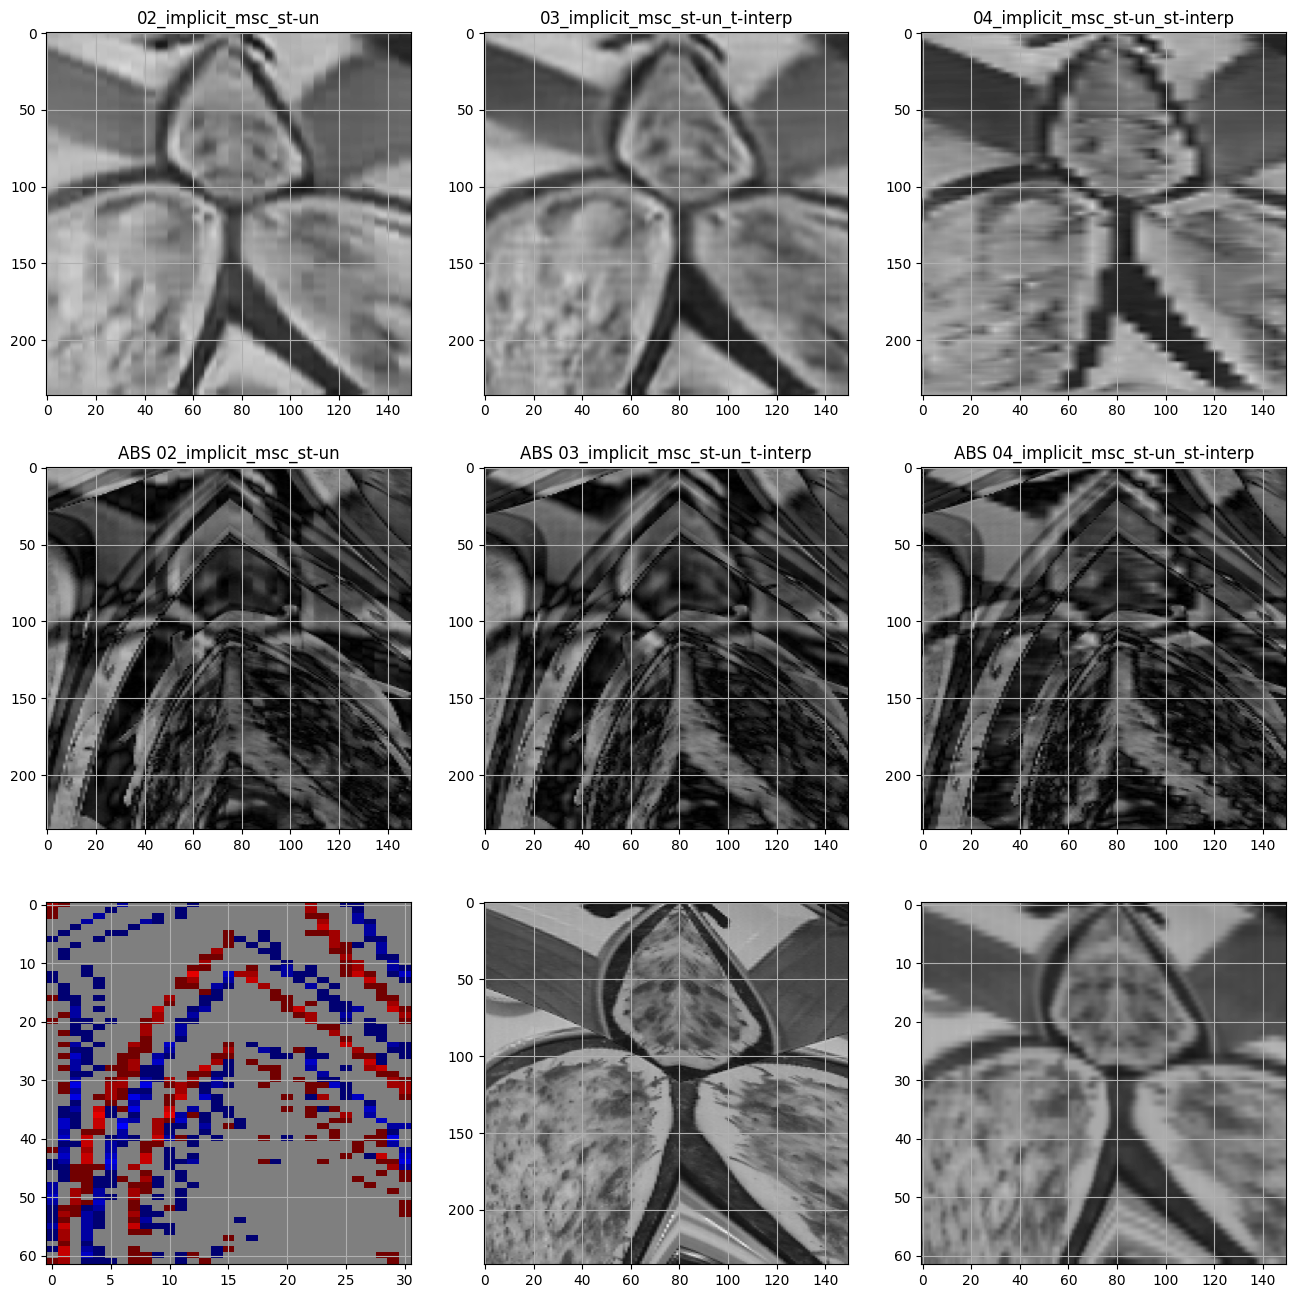

In [4]:
plt.tight_layout()

fig, axs = plt.subplots(3, 3, figsize=(16, 16))

for i, checkpoint_dir in enumerate(checkpoints):
    config_path = checkpoint_dir / "config.json"
    with config_path.open("r", encoding="utf8") as f:
        json_config = f.read()
    # Parse the JSON string back into a Configuration instance
    config = TrainerConfiguration.parse_raw(json_config)

    config.network_loader.decoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"
    config.network_loader.encoding_checkpoint_path = checkpoint_dir / "latest_checkpoint.pt"

    device = torch.device("cuda")

    encoder, decoder = NetworkLoader(config.network_loader, config.shared).run()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    reconstrucion_flat, gt_flat, gt_downscaled, eps = get_reconstructions_and_gt(batch, encoder, decoder, config.shared, device, inference_region=None, Ts_to_evaluate=30, taus_to_evaluate=5)

    x = reconstrucion_flat.shape[1]//2

    axs[0, i].imshow(reconstrucion_flat[:, x].T, cmap="gray", vmin=0, vmax=1, aspect='auto')
    axs[0, i].grid()
    axs[0, i].set_title(f"{checkpoint_dir.name}")

    axs[1, i].imshow(np.abs(reconstrucion_flat[:, x].T - gt_flat[:, 0].T), cmap='gray', vmin=0, vmax=1, aspect='auto')
    axs[1, i].grid()
    axs[1, i].set_title(f"ABS {checkpoint_dir.name}")

axs[2, 1].imshow(gt_flat[:, x].T, cmap="gray", vmin=0, vmax=1,aspect='auto')
axs[2, 1].grid()

X = gt_downscaled.shape[1]//2
axs[2,2].imshow(gt_downscaled[:, X].T, cmap="gray", vmin=0, vmax=1,aspect='auto')
axs[2,2].grid()

X_ev = colored_event_polarity_sums.shape[2] // 2
colored_event_polarity_sums = TrainingMonitor.img_to_colormap(eps.sum(axis=1)[:, X_ev], TrainingMonitor.create_red_blue_cmap(501))
axs[2, 0].imshow(colored_event_polarity_sums.transpose((1, 0, 2)), vmin=0, vmax=1,aspect='auto')
axs[2, 0].grid()
plt.show()

In [7]:
reconstrucion_flat.shape

(100, 316, 236)

In [6]:
gt_downscaled.shape

(100, 83, 62)

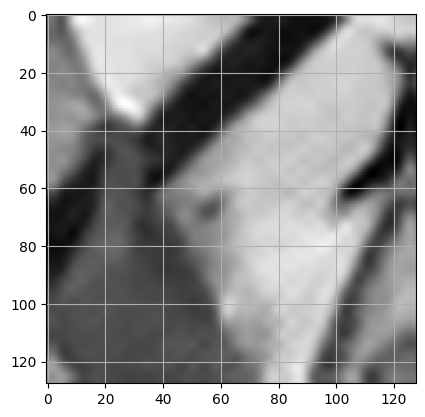

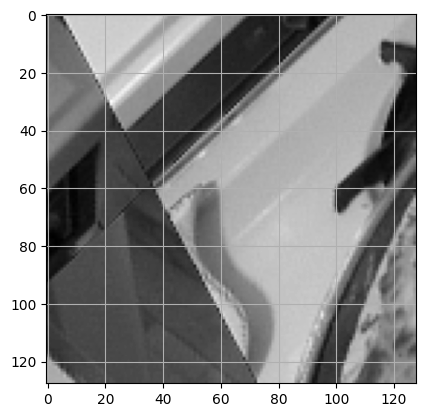

In [4]:
from matplotlib import pyplot as plt

plt.imshow(reconstrucion_flat[0], cmap='gray')
plt.grid()
plt.show()
plt.imshow(gt_flat[0], cmap='gray')
plt.grid()
plt.show()

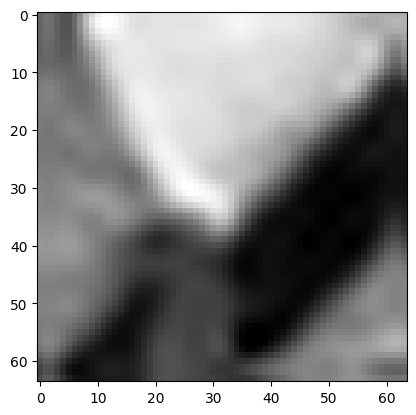

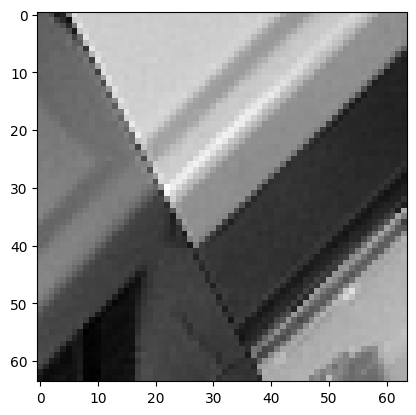

In [22]:
from matplotlib import pyplot as plt

plt.imshow(reconstrucion_flat[0], cmap='gray')
plt.show()
plt.imshow(gt_flat[0], cmap='gray')
plt.show()

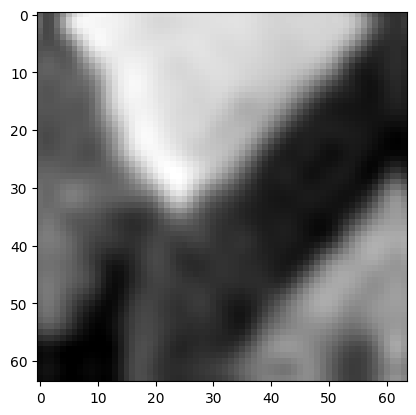

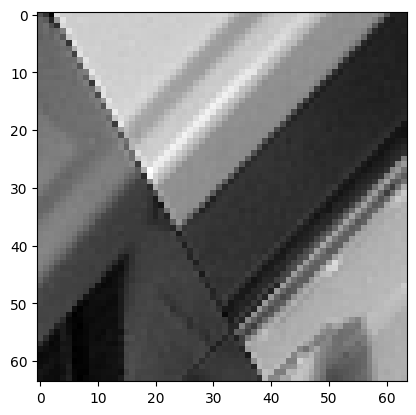

In [27]:
from matplotlib import pyplot as plt

plt.imshow(reconstrucion_flat[0], cmap='gray')
plt.show()
plt.imshow(gt_flat[0], cmap='gray')
plt.show()